# Caribbean and Hawaiian Marine (Reef) Life Image Classification Capstone Project
### Ryan Johnson

#### Week 14 Overview(4/15/2025):



#### Week 13 Overview(4/08/2025):
* Data Augmentation for Training Dataset to improve the model's performance by adding images through image enhancement techniques, including flipping, rotational tilt, zoom quality, and contrast (light/shadow) to improve the model's performance.

* The Convolutional Neural Network (CNN) and Training Model were recreated based on data augmentation techniques.

* New Classification Metrics: The new test loss is 0.603, and the new test accuracy is 0.784. Improvement in the loss where it is lower than the original. The new Confusion Matrix and Classification Report show improvement in the Eagle Ray, Green Sea Turtle, and Stingray, but Cuttlefish and Reef Triggerfish are significant problems that must be addressed.




#### Week 12 Overview(4/01/2025):
* Test dataset directories of Marine Life species: Cuttlefish and reef triggerfish have the lowest number of images for the testing data set, which may lead to misclassification. 

* Predictions based on test dataset: Based on the images above, we can see that most of the marine life species were classified correctly, but cuttlefish and reef triggerfish were misclassified; this can be attributed to the low amount of test images available for each species

* Classification Metrics:  Test Loss: 0.522 and Test Accuracy: 0.789. Confusion Matrix and Classification Report are explained below.



#### Week 11 Overview (3/25/2025):
* Configure the CNN Model: I am telling the model how to learn, specifically looking at optimization, loss function, and metrics to determine the expected outcome.

* EarlyStopping is used to help ensure the model is trained efficiently (saving time) and prevent overfitting. 

* CNN Model Training: The training is based on the CNN neural network created in week 10, which will be used on the training data for the marine species. 

* Training Time: The CNN model runs under 30 minutes.

* Evaluation of Training Results from the CNN model: The plots are the loss and accuracy curves of how the model is learning.



TL:DR
intro and results in the beginning
bullet points

### Project Overview
As an avid snorkeler and someone who has always been interested in the unique Marine reef life ecosystem that exists within the water, I have taken many trips to explore reefs in the ocean and taken enormous amounts of images underwater. Still, I am always at a loss for what I am taking an image of; some marine life creatures I know quite well, including a green sea turtle, but others I am at a complete loss in identifying. The image classification model will create a system in which I can upload distinct sea creatures, and the model can properly identify and allow me to know what exactly I am looking at without needing a guide key to identify different underwater animals and fish that exist. The image classification model is simply a way to speed up my comprehension of the underwater creatures and ecosystems I have explored and identify what the sea creatures are when snorkeling in the ocean with my GoPro when taking enormous amounts of pictures and videos.

### Problem Statement
My capstone project aims to create a Caribbean and Hawaiian Marine (reef) life Single-label image classification model to identify different sea creatures, including sea animals and fish. 

### Caribbean and Hawaiian Marine (Reef) Life Image Classification (Single Label)
The five sea creatures and fish labels I have include:
* Cuttlefish
* Eagle ray
* Green Sea Turtle
* Reef triggerfish
* Stingray

Each of these classes of sea creatures has over 65 images and are a distinct sea creature for creating the single-label image classification model. I took these pictures using my GoPro when snorkeling in the Caribbean and Hawaiian oceans from 2017 to 2025. For my GoPro I have filter lens that help me take a clear image underwater, that is my some of the images have a warming color tone than others. I have 1162 images in total. 


When creating the image classification dataset and annotating the images and videos into each of the label classes there are:
* Cuttlefish- 65 images
* Eagle ray- 366 images
* Green Sea Turtle- 482 images
* Reef triggerfish- 67 images
* Stingray- 182 images

The images are comprised orginal images and videos stripped to 1 image(frame) per second.


In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf

# to build dataset in tensorflow need use datasets
from tensorflow.keras import datasets, layers, models

import sys
import os
from os import listdir

import PIL # Python Imaging Library
from IPython.display import display # Display Images
import pathlib

import random # to set the seed

# confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report


### Using Roboflow's API to Download Dataset into GitHub

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="") # removed api_key becuase it is tied to my Roboflow account.
project = rf.workspace("protozoa").project("caribbean-and-hawaii-marine-life")
version = project.version(1)
dataset = version.download("folder")           

### Caribbean-and-Hawaii-Marine-Life-1 version 1 dataset path

In [125]:
# Caribbean-and-Hawaii-Marine-Life-1 version 1 dataset path
# dataset_path = dataset.location  # folder where the dataset is downloaded

# Needed to put 'r' in front of dataset path to work correctly
dataset_path = r'C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1'

print(dataset_path)

# to remove error use 'r'
# SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape


C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1


### Removed Cuttlefish and Reef triggerfish Classes
The Cuttlefish and Reef triggerfish Classes had small amount of images, which translated to very few testing images which made the model worse. To prevent this I remove the Cuttlefish and Reef triggerfish classes. We are only find three classes and they are ['Eagle ray', 'Green Sea Turtle', 'Stingray'].

### Train, Valid, and Test Dataset Paths

In [126]:
folder_paths_tvt = []
for root, directs, files in os.walk(dataset_path):
    for direct in directs:
        folder_paths_tvt.append(os.path.join(root, direct))

# Print the folder paths
for folder_path in folder_paths_tvt[0:3]:
    print(folder_path)

C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\test
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\train
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\valid


#### Train Data Path

In [127]:
train_data_path = folder_paths_tvt[1]
print(f'Train Data Path:\n{train_data_path}')

Train Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\train


#### Valid Data Path

In [128]:
valid_data_path = folder_paths_tvt[2]
print(f'Valid Data Path:\n{valid_data_path}')

Valid Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\valid


#### Test Data Path

In [129]:
test_data_path = folder_paths_tvt[0]
print(f'Test Data Path:\n{test_data_path}')

Test Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\test


### Listed Directories from the Dataset (Folders for Each of the Classes)

In [130]:
total_files = 0
# root, directory, files in the path of the folder
for root, direc, files in os.walk(str(dataset_path)):
    
    # spliting up the levels of folder files within the main folder
    folder_levels = root.replace(str(dataset_path), '').count(os.sep)
    
    # adding spacing to directories
    spacing = ' ' * (folder_levels) * 5
    
    print(f'{spacing}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
    
print()   
print(f'There are {total_files -2} images in this dataset')

Caribbean-and-Hawaii-Marine-Life-1/ (2 files)
     test/ (0 files)
          Eagle ray/ (36 files)
          Green Sea Turtle/ (48 files)
          Stingray/ (17 files)
     train/ (0 files)
          Eagle ray/ (260 files)
          Green Sea Turtle/ (337 files)
          Stingray/ (131 files)
     valid/ (0 files)
          Eagle ray/ (70 files)
          Green Sea Turtle/ (97 files)
          Stingray/ (34 files)

There are 1030 images in this dataset


## Creating training validation, and test datasets for Caribbean and Hawaiian Marine Life Images

### Setting the seed to reproduce results

In [131]:
set_seed = 81 # 48

os.environ['PYTHONHASHSEED']=str(set_seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(set_seed)
np.random.seed(set_seed)
tf.random.set_seed(set_seed)

### Loading and Preprocessing Caribbean and Hawaiian Marine Life Images

In [132]:
batch_size = 32
image_height = 500 # the image is (500, 500)
image_width = 500
channels = 3 # Channel is (3) for RGB colors

In [133]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_path, # train folder contains all the folders contaning the 3 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  #validation_split= train_test_split,
  #subset="training",
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width),
  batch_size=batch_size
)

Found 728 files belonging to 3 classes.


In [134]:
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_path, # valid folder contains all the folders contaning the 3 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width),
  batch_size=batch_size
)

Found 201 files belonging to 3 classes.


In [135]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_path, # test folder contains all the folders contaning the 3 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width), # 500, 500
  batch_size=batch_size
)

Found 101 files belonging to 3 classes.


### Caribbean and Hawaiian Marine Life Images Label Classes

In [136]:
car_hawai_labels = train_data.class_names
print(f'The Classes for the Caribbean and Hawaiian Marine Life Images are:\n{car_hawai_labels}')

The Classes for the Caribbean and Hawaiian Marine Life Images are:
['Eagle ray', 'Green Sea Turtle', 'Stingray']


### Training Images of Caribbean and Hawaiian Marine Life

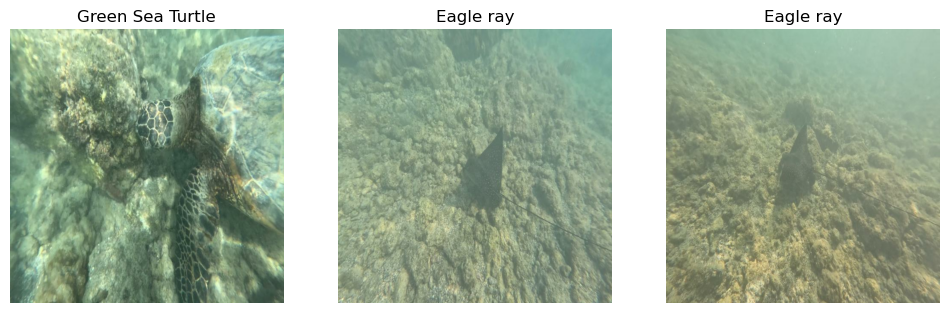

In [137]:
plt.figure(figsize=(12, 12))
for imag, lab in train_data.take(1): # take(1) for the 1 batch (32 images)
    for i in range(3):
        ax = plt.subplot(2, 3, i + 1) # better spacing
        plt.axis("off") # not axis
        plt.imshow(imag[i].numpy().astype("uint16"))
        plt.title(car_hawai_labels[lab[i]])

In [16]:
for imag, lab in train_data.take(1):
    print(f'Image Batch Shape: {imag.shape}\nLabel Batch Shape: {lab.shape}')
    
# Image Batch Shape:
# 1. number of images per batch (32)
# 2. Height of the image (500)
# 3. Width of the image (500)
# 4. Channel is (3) for RGB colors

Image Batch Shape: (32, 500, 500, 3)
Label Batch Shape: (32,)


### Optimizing Performance for the Caribbean and Hawaiian Marine life dataset
Speeding up training by reducing how the data is loaded from GitHub. TensorFlow engine can iterate over the images and process them in a streaming fashion. 
* cache() stores the dataset after loading them off the disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 
* shuffle() is used for making the data order random, preventing overfiting to occur.
* prefetch() overlaps with data preprocessing and model execution while training.

In [17]:
autotune = tf.data.AUTOTUNE # autotune for runtime to have the optimal performance.

# train dataset optimization
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=autotune)

# valid dataset optimization
valid_data = valid_data.cache().prefetch(buffer_size=autotune)

# test dataset optimization
test_data = test_data.cache().prefetch(buffer_size=autotune)

### Creating Convolutional Neural Network (CNN) Model for Marine Life Images
Goal: Classify caribbean and hawaiian marine life images into categories (labels).

**Note:** Data Normalization included in the layers in the CNN model

In [18]:
# Image Batch Shape:
# 1. number of images per batch (32)-- batch_size = 32
# 2. Height of the image (500)-- image_height = 500 
# 3. Width of the image (500)-- image_width = 500
# 4. Channel is (3) for RGB colors-- channels = 3 

print(f'There are {channels} channels in the marine life images (RGB colors).')

num_class = len(car_hawai_labels) # number of classes(labels) of marine life species
print(f'There are {num_class} classes for the Caribbean and Hawaiian Marine life image dataset.')

marineLife_model = tf.keras.Sequential([
  # Normalization layer 
  # normalize values [0, 255] to [0, 1] to help model train with more accurately
  #                                                              Shape of input images: (500, 500, 3)
  layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_height, image_width, channels)),

  # normalize the data
  # using layers.experimental.preprocessing convert to number of 1 and 0
  # rescaling range of the pixel values in the images is between 0 and 255.

  ### Convolutional layers ### -----------------------------------

  # padding='same' is used to keep the output size the same as input 
  # activation='relu' is used to lean about patterns by using non-linearity
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # 2x2 window- downsampling the images

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # layers.Conv2D(256, 3, padding='same', activation='relu'), # don't use leads to overfitting
  # layers.MaxPooling2D(),

  #--------------------------------------------------------------

  layers.Flatten(), # Flatten Layer
  layers.Dense(256, activation='relu'), # Dense layer

  # add dropout layer to help prevent overfitting (dropping 50% of neurons)
  layers.Dropout(0.5),

  # Output layer
  # 5 neurons based the the labels
  layers.Dense(num_class, activation='softmax') # using softmax to ensure that each output is between [0, 1] 
                                                # helps with probabilities
])

There are 3 channels in the marine life images (RGB colors).
There are 3 classes for the Caribbean and Hawaiian Marine life image dataset.


### Marine Life CNN Model Architecture Summary

In [19]:
marineLife_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      1

### Configure Marine Life model
The Marine Life model must be configured to ensure the model can be trained. There are 5 classes.

In [20]:
marineLife_model.compile(optimizer='adam', # optimizing learning rate
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

### Train the Marine Life model
Using early stopping when training the model to ensure that memory is used properly and prevent overfitting to occur.
The training will be stopped in 3 epochs if there is no improvement.

In [21]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 4) # stoped in 3 epochs if no improvement
history = marineLife_model.fit(train_data,
                                 epochs= 25, # 20
                                 validation_data= valid_data,
                                 callbacks= [callback], verbose= 1)

# 3 stopped and 20 eppoch
# - loss: 0.6254 - accuracy: 0.7491 - val_loss: 0.8048 - val_accuracy: 0.7401
# CPU times: total: 2h 30min 33s
# Wall time: 16min 34s

Epoch 1/25
23/23 [==============================] - 80s 3s/step - loss: 1.4103 - accuracy: 0.4684 - val_loss: 0.7935 - val_accuracy: 0.6866
Epoch 2/25
23/23 [==============================] - 86s 4s/step - loss: 0.7959 - accuracy: 0.6085 - val_loss: 0.7396 - val_accuracy: 0.6269
Epoch 3/25
23/23 [==============================] - 79s 3s/step - loss: 0.7540 - accuracy: 0.6525 - val_loss: 0.7736 - val_accuracy: 0.6070
Epoch 4/25
23/23 [==============================] - 79s 3s/step - loss: 0.6649 - accuracy: 0.7074 - val_loss: 0.7476 - val_accuracy: 0.7065
Epoch 5/25
23/23 [==============================] - 85s 4s/step - loss: 0.7249 - accuracy: 0.6690 - val_loss: 0.6005 - val_accuracy: 0.7562
Epoch 6/25
23/23 [==============================] - 86s 4s/step - loss: 0.6049 - accuracy: 0.7349 - val_loss: 0.5803 - val_accuracy: 0.7463
Epoch 7/25
23/23 [==============================] - 86s 4s/step - loss: 0.6677 - accuracy: 0.6992 - val_loss: 0.6403 - val_accuracy: 0.7015
Epoch 8/25
23/23 [==

### Evaluation of Training Results from CNN Model
Plotting the  accuracy and loss curves to show how the model is learning.

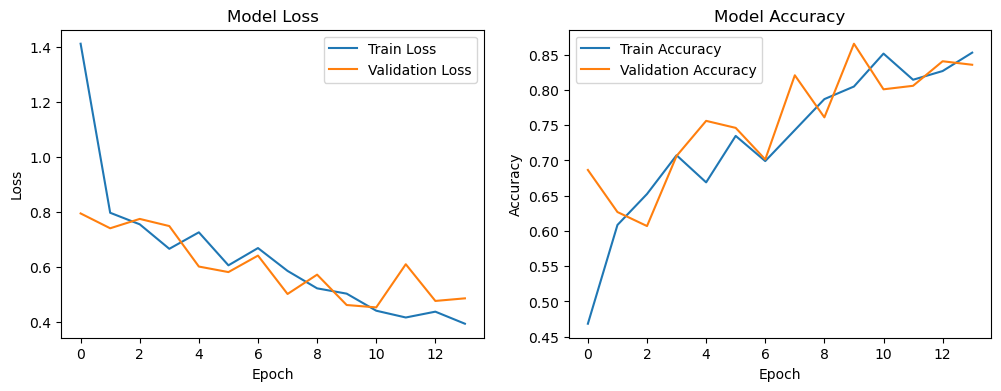

In [22]:
trainHistory = pd.DataFrame(history.history)

# figure size
plt.figure(figsize=(12,4))

# Plotting Train and Valid Loss

# subplot to put the graphs next to each other
plt.subplot(1, 2, 1)

plt.plot(trainHistory['loss'], label='Train Loss')
plt.plot(trainHistory['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#---------------------------------------------------------------------
#---------------------------------------------------------------------

# Plotting Train and Valid Accuracy

# subplot to put the graphs next to each other
plt.subplot(1, 2, 2)

plt.plot(trainHistory['accuracy'], label='Train Accuracy')
plt.plot(trainHistory['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### **The Left Plot is the Model Loss:**
In the model loss plot on the left, we see that both the training and validation loss are decreasing over epochs, which is the training that is occurring. At epoch 11 for the validation loss, there is a spike due to a small overfitting moment that occurred while training for the model. Other than that, there are no other issues. The validation loss continues to decrease after the spike occurs. The final result for training loss is around 0.6, and the validation loss is around 0.7. A small gap between them may indicate some overfitting is occurring.

##### **The Right Plot is the Model Accuracy:**
In the model accuracy on the right, both the training and validation accuracies are improving over each running and training epoch. Around epoch one, validation accuracy increases above the training accuracy, which is common because of the random initialization. The model accuracy for training is around 0.76, and the validation is around 0.78. Both of these accuracies are close together.


### Loss and Accuracy of valid_data
The evaluation for the validation data is that the loss is around 0.71, and the accuracy is around 0.78, indicating that the model classifies the marine life images properly in 4 out of 5 images overall.

In [23]:
loss, acc = marineLife_model.evaluate(valid_data)
print(f'Loss: {round(loss, 6)}\nAccuracy: {round(acc, 6)}')

7/7 [==============================] - 4s 603ms/step - loss: 0.4849 - accuracy: 0.8358
Loss: 0.48492
Accuracy: 0.835821


In [24]:
## Data Augmentation for test data only is not needed

## Data Augmentation for Training Dataset Only

In [25]:
data_aug = tf.keras.Sequential(
  [ # Flipping image
    layers.RandomFlip("horizontal", input_shape=(image_height, image_width, channels)), # (500, 500, 3)
    layers.RandomRotation(0.15), # tilt 
    layers.RandomZoom(0.2), # chnage zoom
    layers.RandomContrast(0.2), # light/shadow
  ]
)

### (NEW) Recreating Convolutional Neural Network (CNN) Model and Training Model
add dropout layer to help prevent overfitting (dropping 50% of neurons)

In [26]:
print(f'There are {channels} channels in the marine life images (RGB colors).')

num_class = len(car_hawai_labels) # number of classes(labels) of marine life species
print(f'There are {num_class} classes for the Caribbean and Hawaiian Marine life image dataset.')

marineLife_model = tf.keras.Sequential([
  data_aug, # Data augmentation

  # Normalization layer 
  # normalize values [0, 255] to [0, 1] to help model train with more accurately
  #                                                              Shape of input images: (500, 500, 3)
  layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_height, image_width, channels)),

  # normalize the data
  # using layers.experimental.preprocessing convert to number of 1 and 0
  # rescaling range of the pixel values in the images is between 0 and 255.

  ### Convolutional layers ### -----------------------------------

  # padding='same' is used to keep the output size the same as input 
  # activation='relu' is used to lean about patterns by using non-linearity
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # 2x2 window- downsampling the images

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Dropout(0.3),  # dropout deeper layer
  layers.MaxPooling2D(),

  #--------------------------------------------------------------

  layers.Flatten(), # Flatten Layer
  layers.Dense(256, activation='relu'), # Dense layer

  # add dropout layer to help prevent overfitting (dropping 50% of neurons)
  layers.Dropout(0.5),

  # Output layer
  # 5 neurons based the the labels
  layers.Dense(num_class, activation='softmax') # using softmax to ensure that each output is between [0, 1] 
                                                # helps with probabilities
])


### Reconfigure Marine Life model
marineLife_model.compile(optimizer='adam', # optimizing learning rate
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])


There are 3 channels in the marine life images (RGB colors).
There are 3 classes for the Caribbean and Hawaiian Marine life image dataset.


### ReTrain the Marine Life model

In [27]:
%%time

callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 4) # stoped in 4 epochs if no improvement
history2 = marineLife_model.fit(train_data,
                                 epochs= 25, # 20
                                 validation_data= valid_data,
                                 callbacks= [callback2], verbose= 1)

Epoch 1/25
23/23 [==============================] - 92s 4s/step - loss: 1.6126 - accuracy: 0.3915 - val_loss: 0.9816 - val_accuracy: 0.5323
Epoch 2/25
23/23 [==============================] - 71s 3s/step - loss: 0.9188 - accuracy: 0.5330 - val_loss: 0.8223 - val_accuracy: 0.6119
Epoch 3/25
23/23 [==============================] - 57s 2s/step - loss: 0.8308 - accuracy: 0.6044 - val_loss: 0.7835 - val_accuracy: 0.6617
Epoch 4/25
23/23 [==============================] - 58s 3s/step - loss: 0.8266 - accuracy: 0.6016 - val_loss: 0.7056 - val_accuracy: 0.6617
Epoch 5/25
23/23 [==============================] - 62s 3s/step - loss: 0.7893 - accuracy: 0.6030 - val_loss: 0.6983 - val_accuracy: 0.7015
Epoch 6/25
23/23 [==============================] - 61s 3s/step - loss: 0.6785 - accuracy: 0.6841 - val_loss: 0.6555 - val_accuracy: 0.7114
Epoch 7/25
23/23 [==============================] - 58s 3s/step - loss: 0.7131 - accuracy: 0.6552 - val_loss: 0.6741 - val_accuracy: 0.7015
Epoch 8/25
23/23 [==

### NEW Marine Life CNN Model Architecture Summary

In [28]:
marineLife_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 250, 250, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                 

### Re-Evaluation of Training Results from CNN Model

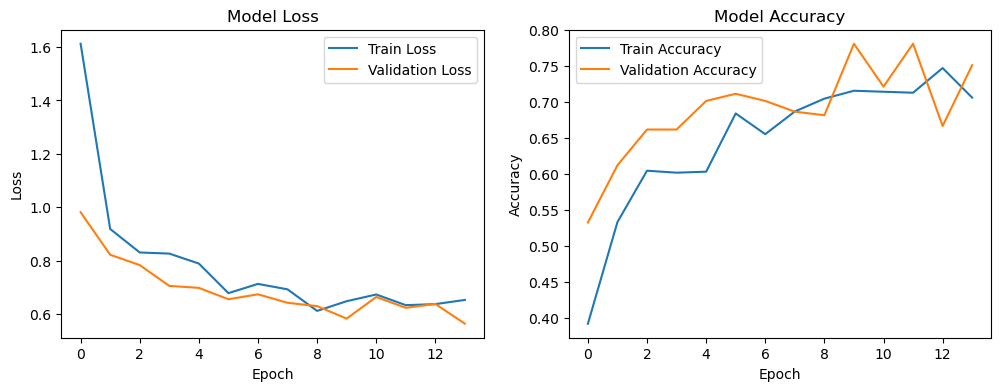

In [29]:
trainHistory2 = pd.DataFrame(history2.history)

# figure size
plt.figure(figsize=(12,4))

# Plotting Train and Valid Loss

# subplot to put the graphs next to each other
plt.subplot(1, 2, 1)

plt.plot(trainHistory2['loss'], label='Train Loss')
plt.plot(trainHistory2['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#---------------------------------------------------------------------
#---------------------------------------------------------------------

# Plotting Train and Valid Accuracy

# subplot to put the graphs next to each other
plt.subplot(1, 2, 2)

plt.plot(trainHistory2['accuracy'], label='Train Accuracy')
plt.plot(trainHistory2['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### New Loss and Accuracy of valid_data

In [30]:
new_loss, new_acc = marineLife_model.evaluate(valid_data)
print(f'New Loss: {round(new_loss, 6)}\n New Accuracy: {round(new_acc, 6)}')

7/7 [==============================] - 2s 351ms/step - loss: 0.5640 - accuracy: 0.7512
New Loss: 0.563963
 New Accuracy: 0.751244


## Testing Caribbean and Hawaiian Marine Life CNN model using Test dataset

### Listed Directories from the Testing Dataset Path (Folders for Each of the Classes)

In [31]:
total_files = 0
# root, directory, files in the path of the folder
for root, direc, files in os.walk(str(test_data_path)):
    
    # spliting up the levels of folder files within the main folder
    folder_levels = root.replace(str(test_data_path), '').count(os.sep)
    
    # adding spacing to directories
    spacing = ' ' * (folder_levels) * 5
    
    print(f'{spacing}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
    
print()   
print(f'There are {total_files} images in the testing dataset.')

test/ (0 files)
     Eagle ray/ (36 files)
     Green Sea Turtle/ (48 files)
     Stingray/ (17 files)

There are 101 images in the testing dataset.


### Remove test data classes Cuttlefish and Reef triggerfish because low number of files
low number of images for these two classes, don't need to use them in new prediction data. 
More problems if I use Cuttlefish and Reef triggerfish classes

In [32]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Predictions of Caribbean and Hawaiian Marine Life Based on Test Dataset Images
These are the some of predictions for the test images for the test dataset.

The CNN model has not seen this data before; along with each of the individual test images is the true label on what the image originally classified as, the predicted label based on the prediction from the CNN model on what the species will be, and finally the confidence score, this score shows the user to see the overall confidence that the model has that it classified the species correctly.

1/1 [==============================] - 1s 509ms/step


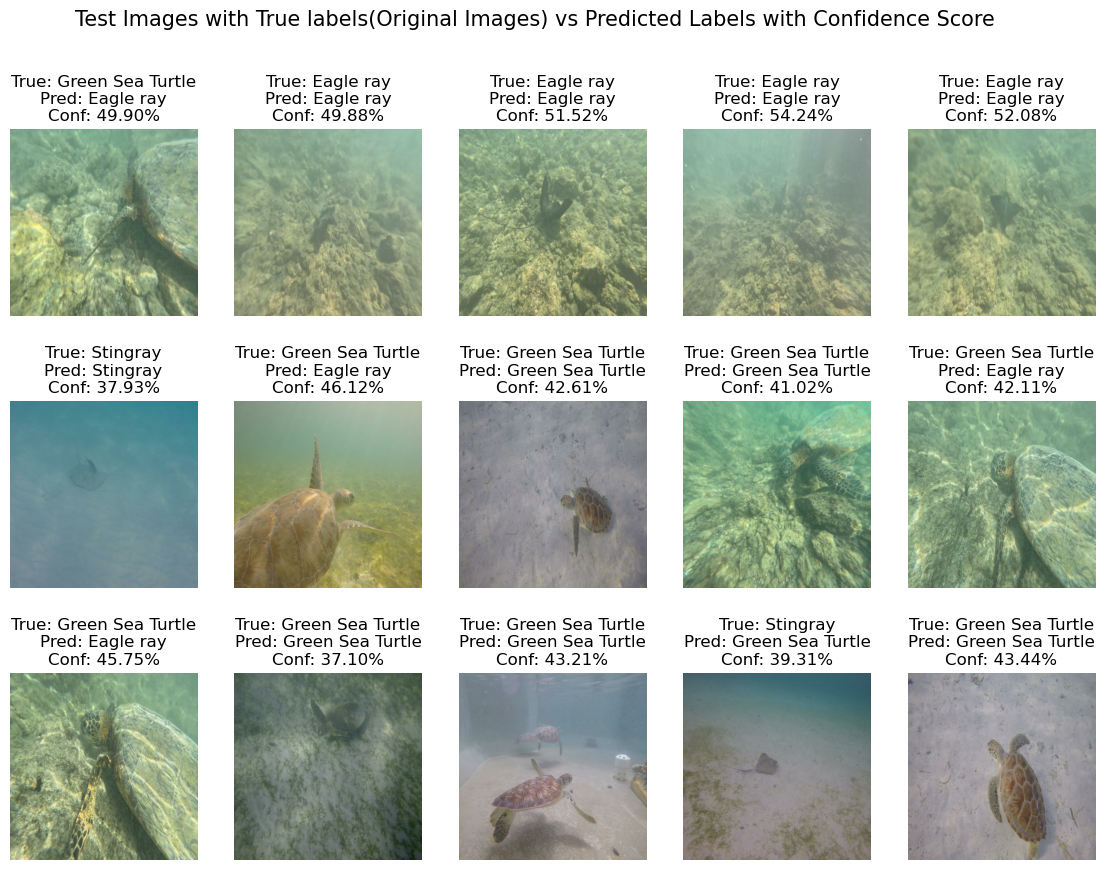

In [33]:
for imag, lab in test_data.take(1): # take(1) for the 1 batch (32 images)
    predict = marineLife_model.predict(imag) # predictions of marine life images
    score = tf.nn.softmax(predict)
    
    plt.figure(figsize=(14, 10))
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.axis("off") # not axis
        plt.imshow(imag[i].numpy().astype("uint8"))

        # added .numpy() to ensure that I am working with numpy arrays
        # converting Tensorflow tensors into numpy arrays
        # helps with visualization of images results for plotting 
        
        true_label = car_hawai_labels[lab[i].numpy()] # original label

        pred_score_index = np.argmax(score[i].numpy()) # index of the highest confidence score
        pred_label = car_hawai_labels[pred_score_index] # new predicted label

        confidence_score = 100 * np.max(score[i].numpy()) # confidence score

        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence_score:.2f}%")

        # Original test image, predict label with Confidence score per image 
        #print(f"Image {i+1}: True label(Original Image): '{true_label}'. Predicted Image is '{pred_label}' with {confidence_score:.2f}% confidence.")

    plt.suptitle("Test Images with True labels(Original Images) vs Predicted Labels with Confidence Score", fontsize=15)
    plt.show()

Based on the images above, we can see that most of the marine life species were classified correctly, but cuttlefish and reef triggerfish were misclassified; this can be attributed to the low amount of test images available for each species. The conference score is also quite low. Overall, it is incredible to see how well the CNN model performed; by seeing these visualizations, the user can clearly understand how well the model performed in classifying each marine life species in a dataset.

## Classification Metrics
* Test Loss and Accuracy
* Confusion Matrix
* Classification Report

### Evaluate Loss and Accuracy of Test Data
The Test Loss: 0.522 and Test Accuracy: 0.789. The loss shows how poorly the model is performing on the unseen data. A lower loss indicates better performance. The accuracy is nearly 79% based on the test dataset, which is a good starting point in determining how well the model performed.

In [34]:
test_loss, test_acc = marineLife_model.evaluate(test_data)
print(f'Test Loss: {round(test_loss, 6)}\nTest Accuracy: {round(test_acc, 6)}')

4/4 [==============================] - 1s 291ms/step - loss: 0.5247 - accuracy: 0.8020
Test Loss: 0.524717
Test Accuracy: 0.80198


##### Predictions of Test Data

In [35]:
y_pred = marineLife_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

4/4 [==============================] - 1s 279ms/step


##### True Labels of Test Data

In [36]:
y_test = np.concatenate([y for x, y in test_data], axis=0)

### The Label Names of each of the Caribbean and Hawaiian Marine life Images 
(Names of each of the classes)

In [37]:
print(car_hawai_labels)

['Eagle ray', 'Green Sea Turtle', 'Stingray']


### Confusion Matrix

In [38]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm, index=car_hawai_labels, columns=car_hawai_labels)

,Eagle ray,Green Sea Turtle,Stingray
Eagle ray,36,0,0
Green Sea Turtle,8,39,1
Stingray,0,11,6


##### Confusion Matrix Explained
* **Cuttlefish**: One image was correctly identified, and five were misclassified as green sea turtle, showing confusion about the cuttlefish marine life species.
* **Eagle ray**: 35 images were correctly identified, and one was misclassified as a green sea turtle. Their overall performance for Eagle Ray is of a high accuracy.
* **Green Sea Turtle**: 42 images were correctly classified; five were misclassified as eagle ray, and one was misclassified as stingray. Other than some confusion with Eagle Ray and Stingray, it was a solid overall performance.
* **Reef triggerfish**: poor performance, zero correctly classified, three images misclassified as eagle ray, and four images misclassified as green sea turtle. This indicates insufficient data for the reef triggerfish, and more is needed.
* **Stingray**: 12 images were correctly classified, and five were misclassified as green sea turtle.

The confusion matrix shows a problem: classifying cuttlefish and reef triggerfish. Data augmentation is needed, especially for these species. Other than that, there's a slightly missed classification of images, but I hope data augmentation will help correct that.

### Classification Report

In [39]:
import warnings 
warnings.filterwarnings('ignore') # ignore the warnings to occur with classification report


print(classification_report(y_test, y_pred, 
                            target_names=car_hawai_labels))

                  precision    recall  f1-score   support

       Eagle ray       0.82      1.00      0.90        36
Green Sea Turtle       0.78      0.81      0.80        48
        Stingray       0.86      0.35      0.50        17

        accuracy                           0.80       101
       macro avg       0.82      0.72      0.73       101
    weighted avg       0.81      0.80      0.78       101



##### Classification Report Explained
* **Cuttlefish** has a high precision but a very low recall, which indicates it is underrepresented.
* **Eagle Ray** and **Green Sea Turtle** performed extremely well and have a high recall, so they were quickly identified frequently. They both also have good F1 scores, showing they performed well.
* The **Reef Triggerfish** has a big problem in the classification report. It is not recognized at all; there's no representation of any results, which means the test samples are underrepresented.
* **Stingray** performed fairly well but did have some misclassifications with green sea turtles.

Based on the classification report, reef triggerfish is the most critical issue that must be addressed to ensure the overall model performance.